## 准备阶段

In [33]:
import time
import csv, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from cv2 import resize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn import preprocessing
import copy
import torchvision
import torchvision.transforms as transforms

In [2]:
# ---------------
# Visual The Loss
# ---------------
def draw_loss_acc(train_list,validation_list,mode='Loss'):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 1, 1)
    # 设置间隔
    data_len = len(train_list)
    x_ticks = np.arange(1,data_len+1)
    plt.xticks(x_ticks)
    if mode == 'Loss':
        plt.plot(x_ticks,train_list,label='Train Loss')
        plt.plot(x_ticks,validation_list,label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('Epoch_loss.jpg')
    elif mode == 'Accuracy':
        plt.plot(x_ticks,train_list,label='Train Accuracy')
        plt.plot(x_ticks,validation_list,label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig('Epoch_Accuracy.jpg')

In [3]:
# ----------------
# Train the model
# ----------------
def train_model(model, criterion, optimizer, dataloaders, train_datalengths, scheduler=None, num_epochs=2):
    """传入的参数分别是:
    1. model:定义的模型结构
    2. criterion:损失函数
    3. optimizer:优化器
    4. dataloaders:training dataset
    5. train_datalengths:train set和validation set的大小, 为了计算准确率
    6. scheduler:lr的更新策略
    7. num_epochs:训练的epochs
    """
    since = time.time()
    # 保存最好一次的模型参数和最好的准确率
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss = [] # 记录每一个epoch后的train的loss
    train_acc = []
    validation_loss = []
    validation_acc = []
    for epoch in range(num_epochs):
        print('Epoch [{}/{}]'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler != None:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0 # 这个是一个epoch积累一次
            running_corrects = 0 # 这个是一个epoch积累一次

            # Iterate over data.
            total_step = len(dataloaders[phase])
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                # inputs = inputs.reshape(-1, 28*28).to(device)
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # 使用output(概率)得到预测
                    
                    loss = criterion(outputs, labels) # 使用output计算误差

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if (i+1)%100==0:
                    # 这里相当于是i*batch_size的样本个数打印一次, i*100
                    iteration_loss = loss.item()/inputs.size(0)
                    iteration_acc = 100*torch.sum(preds == labels.data).item() / len(preds)
                    print ('Mode {}, Epoch [{}/{}], Step [{}/{}], Accuracy: {}, Loss: {:.4f}'.format(phase, epoch+1, num_epochs, i+1, total_step, iteration_acc, iteration_loss))
            
            epoch_loss = running_loss / train_datalengths[phase]
            epoch_acc = running_corrects.double() / train_datalengths[phase]
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                validation_loss.append(epoch_loss)
                validation_acc.append(epoch_acc)
            print('*'*10)
            print('Mode: [{}], Loss: {:.4f}, Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            print('*'*10)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('*'*10)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('*'*10)
    # load best model weights
    final_model = copy.deepcopy(model) # 最后得到的model
    model.load_state_dict(best_model_wts) # 在验证集上最好的model
    draw_loss_acc(train_list=train_loss,validation_list=validation_loss,mode='Loss') # 绘制Loss图像
    draw_loss_acc(train_list=train_acc,validation_list=validation_acc,mode='Accuracy') # 绘制准确率图像
    return (model,final_model)

In [7]:
# --------------------
# Device configuration
# --------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------
# Hyper-parameters 
# ----------------
num_classes = 10
num_epochs = 3
batch_size = 100
validation_split = 0.05 # 每次训练集中选出10%作为
learning_rate = 0.001

## 数据定义

In [22]:
# -------------
# MNIST dataset 
# -------------
train_dataset = torchvision.datasets.MNIST(root='./',
                                        train=True, 
                                        transform=transforms.ToTensor(),
                                        download=True)

test_dataset = torchvision.datasets.MNIST(root='./',
                                        train=False, 
                                        transform=transforms.ToTensor())
# -----------
# Data loader
# -----------
test_len = len(test_dataset) # 计算测试集的个数
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=batch_size, 
                                        shuffle=False)

for (inputs,labels) in test_loader:
    print(inputs.size())
    print(labels.size())
    break
# ------------------
# 下面切分validation
# ------------------
dataset_len = len(train_dataset)
indices = list(range(dataset_len))
# Randomly splitting indices:
val_len = int(np.floor(validation_split * dataset_len)) # validation的长度
validation_idx = np.random.choice(indices, size=val_len, replace=False) # validatiuon的index
train_idx = list(set(indices) - set(validation_idx)) # train的index
## Defining the samplers for each phase based on the random indices:
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            sampler=train_sampler,
                                            batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(train_dataset,
                                            sampler=validation_sampler,
                                            batch_size=batch_size)
train_dataloaders = {"train": train_loader, "val": validation_loader} # 使用字典的方式进行保存
train_datalengths = {"train": len(train_idx), "val": val_len} # 保存train和validation的长度

torch.Size([100, 1, 28, 28])
torch.Size([100])


## 模型定义

In [2]:
# -------------------------------------------------------
# Convolutional neural network (two convolutional layers)
# -------------------------------------------------------
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [7]:
# 模型初始化
model = ConvNet(num_classes=num_classes).to(device)

# 打印模型结构
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


Epoch [1/3]
----------
Mode train, Epoch [1/3], Step [100/570], Accuracy: 94.0, Loss: 0.0018
Mode train, Epoch [1/3], Step [200/570], Accuracy: 97.0, Loss: 0.0008
Mode train, Epoch [1/3], Step [300/570], Accuracy: 98.0, Loss: 0.0007
Mode train, Epoch [1/3], Step [400/570], Accuracy: 97.0, Loss: 0.0006
Mode train, Epoch [1/3], Step [500/570], Accuracy: 99.0, Loss: 0.0004
**********
Mode: [train], Loss: 0.1659, Acc: 0.9553
**********
**********
Mode: [val], Loss: 0.0591, Acc: 0.9797
**********

Epoch [2/3]
----------
Mode train, Epoch [2/3], Step [100/570], Accuracy: 100.0, Loss: 0.0001
Mode train, Epoch [2/3], Step [200/570], Accuracy: 99.0, Loss: 0.0006
Mode train, Epoch [2/3], Step [300/570], Accuracy: 99.0, Loss: 0.0003
Mode train, Epoch [2/3], Step [400/570], Accuracy: 100.0, Loss: 0.0002
Mode train, Epoch [2/3], Step [500/570], Accuracy: 99.0, Loss: 0.0003
**********
Mode: [train], Loss: 0.0484, Acc: 0.9858
**********
**********
Mode: [val], Loss: 0.0521, Acc: 0.9823
**********

Ep

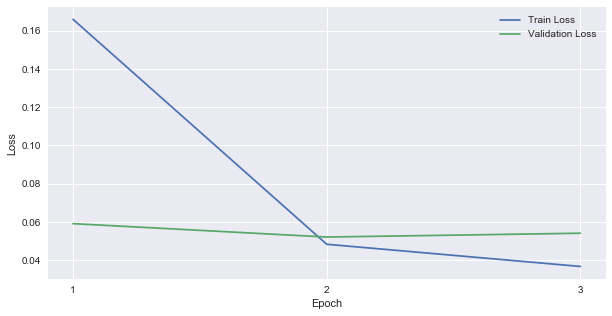

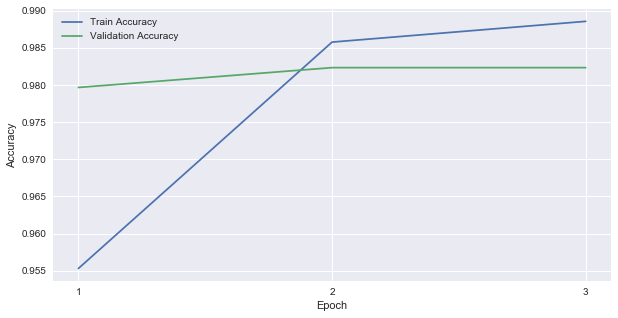

In [10]:
# -------------------
# Loss and optimizer
# ------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# -------------
# 进行模型的训练
# -------------
(best_model,final_model) = train_model(model=model,criterion=criterion,optimizer=optimizer,dataloaders=train_dataloaders,train_datalengths=train_datalengths,num_epochs=num_epochs)

## 模型的保存

In [12]:
torch.save(model, 'CNN_MNIST.pkl')

## 模型的加载

In [3]:
model = torch.load('CNN_MNIST.pkl')

## 模型的测试

In [27]:
test_dataset.data[0].shape

torch.Size([28, 28])

In [25]:
unload = transforms.ToPILImage()
unload(test_dataset.data[0])

In [24]:
test_dataset.targets[0]

tensor(7)

In [23]:
# 带入模型进行预测
inputdata = test_dataset.data[0].view(1,1,28,28).float()/255
inputdata = inputdata.to(device)
outputs = model(inputdata)
outputs

tensor([[ -4.6164,  -4.6860,  -2.4694,   0.9703,  -9.9539,  -4.8575, -15.4606,
          12.0382,  -6.5464,   0.2383]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [11]:
# 查看预测结果
torch.max(outputs, 1)

(tensor([12.0382], device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([7], device='cuda:0'))

## 查看feature map

In [4]:
# hook类的写法
class SaveFeatures():
    """注册hook和移除hook
    """
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        # self.features = output.clone().detach().requires_grad_(True)
        self.features = output.clone()
    def close(self):
        self.hook.remove()

In [58]:
# 一共有两个卷积层
list(model.children())[0][0]

Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

In [78]:
# hook住模型
layer = 0 # 第layer层卷积层
activations = SaveFeatures(list(model.children())[layer][0])

# 超参数
lr = 0.1 # 学习率
opt_steps = 500 # 迭代次数
upscaling_factor = 10 # 放大的倍数



# 带入网络进行迭代
for f in range(0,16):
   # 初始化随机图片
    sz = 28
    img = np.uint8(np.random.uniform(0, 255, (1, sz, sz)))/255
    img = torch.from_numpy(img[None]).float().to(device)
    img_var = Variable(img, requires_grad=True)
    # 定义优化器
    optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
    for n in range(opt_steps):  # optimize pixel values for opt_steps times
        optimizer.zero_grad()
        model(img_var) # 正向传播
        loss = -activations.features[0, f].mean() # loss相当于最大该层的激活的值
        loss.backward()
        optimizer.step()
    # print(activations.features[0].view(16,28*28).mean(1))
    print(activations.features.shape)
    print('========')
    # 打印最后的img的样子
    img = img_var.cpu().clone()
    img = img.squeeze(0)
    unloader = transforms.ToPILImage()
    img = unloader(img)
    img = cv2.cvtColor(np.asarray(img),cv2.COLOR_RGB2BGR)
    sz = int(upscaling_factor * sz)  # calculate new image size
    img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
    cv2.imwrite('layer0_filter{}.jpg'.format(f),img)

# 移除hook
activations.close()

torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])


## 想要输出是1, 看输出是什么

In [5]:
model.state_dict()['layer1.0.weight'][1]

tensor([[[-0.1163,  0.0831, -0.0897,  0.0312,  0.0483],
         [-0.0079,  0.0953,  0.1118,  0.1827,  0.0142],
         [ 0.0728,  0.1149,  0.0472, -0.0303, -0.1781],
         [-0.0655,  0.0482, -0.1040,  0.0260, -0.0505],
         [-0.2907, -0.2503, -0.1944, -0.1212, -0.1266]]], device='cuda:0')

In [16]:
list(model.children())[2]

Linear(in_features=1568, out_features=10, bias=True)

In [20]:
# hook住模型
layer = 2
activations = SaveFeatures(list(model.children())[layer])

# 超参数
lr = 0.05 # 学习率
opt_steps = 100 # 迭代次数
upscaling_factor = 10 # 放大的倍数(为了最后图像的保存)

# 保存迭代后的数字
true_nums = []


# 带入网络进行迭代
for true_num in range(0,10):
    # 初始化随机图片(数据定义和优化器一定要在一起)
    # 定义数据
    sz = 28
    img = np.uint8(np.random.uniform(0, 255, (1, sz, sz)))/255
    img = torch.from_numpy(img[None]).float().to(device)
    img_var = Variable(img, requires_grad=True)
    # 定义优化器
    optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
    for n in range(opt_steps):  # optimize pixel values for opt_steps times
        optimizer.zero_grad()
        model(img_var) # 正向传播
        loss = -(activations.features[0, true_num]-activations.features[0].mean()) # loss相当于最大该层的激活的值
        # loss = -activations.features[0, true_num]
        loss.backward()
        optimizer.step()
    # 打印最后的img的样子
    print(activations.features[0, true_num])
    print(activations.features[0])
    print('========')
    img = img_var.cpu().clone()
    img = img.squeeze(0)
    # 图像的裁剪(确保像素值的范围)
    img[img>1]=1
    img[img<0]=0
    true_nums.append(img)
    unloader = transforms.ToPILImage()
    img = unloader(img)
    img = cv2.cvtColor(np.asarray(img),cv2.COLOR_RGB2BGR)
    sz = int(upscaling_factor * sz)  # calculate new image size
    img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
    cv2.imwrite('num_{}.jpg'.format(true_num),img)

# 移除hook
activations.close()

tensor(196.1546, device='cuda:0', grad_fn=<SelectBackward>)
tensor([ 196.1546, -294.8484,   -7.6568, -112.3714, -152.9670, -123.5260,
         -92.3355, -256.8824,   28.9716, -153.6280], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(328.1340, device='cuda:0', grad_fn=<SelectBackward>)
tensor([-361.2679,  328.1340,  120.0587,  -39.1018, -109.6398,  -63.7581,
        -283.5492,  -34.5981, -315.9140, -319.0491], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(507.1016, device='cuda:0', grad_fn=<SelectBackward>)
tensor([-241.7440, -163.1944,  507.1016,  -45.3038, -299.0189, -232.5516,
        -344.2968,  -92.5664, -125.8911, -380.9313], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(522.1756, device='cuda:0', grad_fn=<SelectBackward>)
tensor([-332.2834, -241.8614,   -9.3087,  522.1756, -432.0358,  -28.5559,
        -401.9879,  -94.7131, -106.5323, -190.4074], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(256.4749, device='cuda:0', grad_fn=<SelectBac

In [21]:
for i in range(0,10):
    _ , pre = torch.max(model(true_nums[i][None].to(device)),1)
    print("i:{},Pre:{}".format(i,pre))

i:0,Pre:tensor([8], device='cuda:0')
i:1,Pre:tensor([1], device='cuda:0')
i:2,Pre:tensor([2], device='cuda:0')
i:3,Pre:tensor([3], device='cuda:0')
i:4,Pre:tensor([4], device='cuda:0')
i:5,Pre:tensor([5], device='cuda:0')
i:6,Pre:tensor([6], device='cuda:0')
i:7,Pre:tensor([7], device='cuda:0')
i:8,Pre:tensor([8], device='cuda:0')
i:9,Pre:tensor([9], device='cuda:0')


## 使用正确的图片, 沿着梯度反方向移动

In [56]:
# hook住模型
layer = 2
activations = SaveFeatures(list(model.children())[layer])

# 超参数
lr = 0.005 # 学习率
opt_steps = 70 # 迭代次数
upscaling_factor = 10 # 放大的倍数(为了最后图像的保存)

# 保存迭代后的数字
true_nums = []

# 带入网络进行迭代
for true_num in range(0,10):
    # 初始化随机图片(数据定义和优化器一定要在一起)
    # 定义数据
    sz = 28
    # 将7变成0,1,2,3,4,5,6,7,8,9
    img = test_dataset.data[0].view(1,1,28,28).float()/255
    img = img.to(device)
    img_var = Variable(img, requires_grad=True)
    # 定义优化器
    optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
    for n in range(opt_steps):  # optimize pixel values for opt_steps times
        optimizer.zero_grad()
        model(img_var) # 正向传播
        # 这里的loss确保某个值的输出大, 并且与原图不会相差很多
        loss = -activations.features[0, true_num] + F.mse_loss(img_var,img)
        loss.backward()
        optimizer.step()
    # 打印最后的img的样子
    print(activations.features[0, true_num])
    print(activations.features[0])
    print('========')
    img = img_var.cpu().clone()
    img = img.squeeze(0)
    # 图像的裁剪(确保像素值的范围)
    img[img>1]=1
    img[img<0]=0
    true_nums.append(img)
    unloader = transforms.ToPILImage()
    img = unloader(img)
    img = cv2.cvtColor(np.asarray(img),cv2.COLOR_RGB2BGR)
    sz = int(upscaling_factor * sz)  # calculate new image size
    img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
    cv2.imwrite('real7_regonize{}.jpg'.format(true_num),img)

# 移除hook
activations.close()

tensor(13.0160, device='cuda:0', grad_fn=<SelectBackward>)
tensor([ 13.0160, -18.8720,  -2.3680,  -9.2591,  -9.6613, -10.2659, -12.1550,
          0.5029,  -0.4319,  -2.1710], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(26.0117, device='cuda:0', grad_fn=<SelectBackward>)
tensor([-20.3887,  26.0117,   2.6921,  -6.4331,  -3.2147,  -5.8528, -28.1495,
         17.9849, -31.7930, -15.1926], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(34.4822, device='cuda:0', grad_fn=<SelectBackward>)
tensor([-14.1361,  -7.2388,  34.4822,  -2.0734, -21.4665, -19.7852, -32.1796,
         13.3965, -18.3029, -21.4641], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(35.4379, device='cuda:0', grad_fn=<SelectBackward>)
tensor([-23.3432, -12.6486,   0.3977,  35.4379, -30.4956,  -3.2850, -38.2244,
         11.4169, -15.4760,  -7.9958], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(17.8015, device='cuda:0', grad_fn=<SelectBackward>)
tensor([-17.3047,   6.2924,  -5.2854,

In [57]:
for i in range(0,10):
    _ , pre = torch.max(model(true_nums[i][None].to(device)),1)
    print("i:{},Pre:{}".format(i,pre))

i:0,Pre:tensor([0], device='cuda:0')
i:1,Pre:tensor([7], device='cuda:0')
i:2,Pre:tensor([2], device='cuda:0')
i:3,Pre:tensor([3], device='cuda:0')
i:4,Pre:tensor([4], device='cuda:0')
i:5,Pre:tensor([5], device='cuda:0')
i:6,Pre:tensor([6], device='cuda:0')
i:7,Pre:tensor([7], device='cuda:0')
i:8,Pre:tensor([8], device='cuda:0')
i:9,Pre:tensor([9], device='cuda:0')
